## 모듈 임포트

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

## 데이터 로드

In [ ]:
!wget 'https://bit.ly/3dD5MU9'

import zipfile
with zipfile.ZipFile('3dD5MU9', 'r') as existing_zip:
    existing_zip.extractall('data')

--2021-05-27 08:19:03--  https://bit.ly/3dD5MU9
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://drive.google.com/uc?export=download&id=1kkF00wW8v0npJ8S2nA7--eMTH3gOL03z [following]
--2021-05-27 08:19:03--  https://drive.google.com/uc?export=download&id=1kkF00wW8v0npJ8S2nA7--eMTH3gOL03z
Resolving drive.google.com (drive.google.com)... 142.250.99.101, 142.250.99.113, 142.250.99.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.99.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l7eokqs82ko0t1schp6jqce1j1t9js09/1622103525000/00192245294648390361/*/1kkF00wW8v0npJ8S2nA7--eMTH3gOL03z?e=download [following]
--2021-05-27 08:19:09--  https://doc-14-94-docs.googleusercontent.com/docs/securesc/

In [ ]:
energy = pd.read_csv('data/energy.csv')
dangjin_fcst = pd.read_csv('./data/dangjin_fcst_data.csv')
ulsan_fcst = pd.read_csv('./data/ulsan_fcst_data.csv')

## 데이터 병합 
- 가장 나중의 예측 데이터가 가장 좋다고 가정.

In [ ]:
def to_date(x):
    return timedelta(hours=x)

In [ ]:
def generate_df(df_):
    df = df_.copy()

    df['Forecast_time'] = pd.to_datetime(df['Forecast time'])

    # 20 시
    a = df[df["forecast"] == 4.0]
    a = a[a["Forecast time"].apply(lambda x: "20:00:00" in x)]
    a.loc[:, 'Forecast_time'] = a.loc[:, 'Forecast_time'] + a.loc[:, 'forecast'].map(to_date)

    # 23 시
    b = df[df["forecast"] <= 22]
    b = b[b["Forecast time"].apply(lambda x: "23:00:00" in x)]
    b.loc[:, 'Forecast_time'] = b.loc[:, 'Forecast_time'] + b.loc[:, 'forecast'].map(to_date)

    # 병합
    c = pd.concat([a, b])
    print(f"20시 사용 데이터 길이 : {len(a)}")
    print(f"23시 사용 데이터 길이 : {len(b)}")
    print(f"합친 데이터 길이 : {len(c)}")
    print()

    # 정렬
    c.sort_values(by=['Forecast_time'], inplace=True)
    c = c[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

    return c

In [ ]:
dangjin_filled = generate_df(dangjin_fcst)
ulsan_filled = generate_df(ulsan_fcst)

20시 사용 데이터 길이 : 1096
23시 사용 데이터 길이 : 7672
합친 데이터 길이 : 8768

20시 사용 데이터 길이 : 1096
23시 사용 데이터 길이 : 7672
합친 데이터 길이 : 8768



## 보간

In [ ]:
def interpolate_df(df, method='linear'):
    new_df = pd.DataFrame()
    new_df['Forecast_time'] = pd.date_range(start=df['Forecast_time'].iloc[0], end=df['Forecast_time'].iloc[-1], freq='H')
    new_df = pd.merge(new_df, df, on='Forecast_time', how='outer')
    return new_df.interpolate(method=method)

In [ ]:
dangjin_interpolated = interpolate_df(dangjin_filled, method='linear')
ulsan_interpolated = interpolate_df(ulsan_filled, method='linear')

## 피처엔지니어링

In [ ]:
dangjin_interpolated.Cloud.value_counts()

1.000000    8029
4.000000    6282
3.000000    5654
2.000000    2543
3.333333     690
3.666667     683
2.333333     640
1.666667     448
1.666667     434
2.333333     335
2.666667     325
1.333333     115
1.333333     113
2.666667       7
3.333333       4
Name: Cloud, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


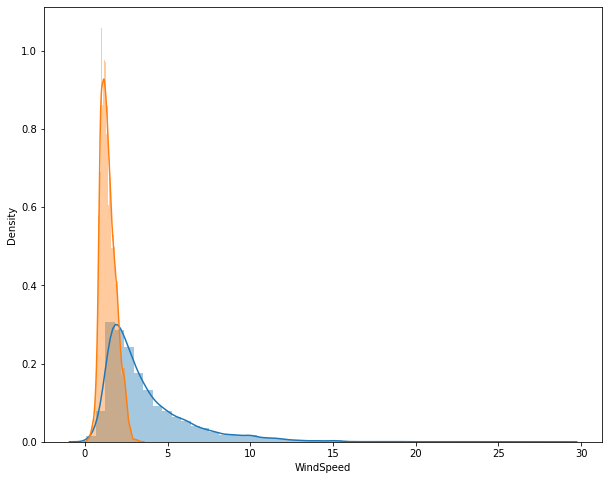

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,8))
col = 'WindSpeed'
sns.distplot(dangjin_interpolated[col])
sns.distplot(np.log1p(dangjin_interpolated[col]))

In [ ]:
!pip install Catboost

     |████████████████████████████████| 67.3MB 52kB/s 


In [ ]:
from catboost import CatBoostRegressor

## 학습 데이터 전처리

In [ ]:
def train_datast(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df.loc[24:]
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df.loc[:25608-1]
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간 및 날짜 정보 feature로 추가
    concat_df['date'] = concat_df['Forecast_time'].str.split(' ').str[0]
    concat_df['hour'] = concat_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    concat_df['year'] = concat_df['date'].str.split('-').str[0].astype(int)
    concat_df['month'] = concat_df['date'].str.split('-').str[1].astype(int)
    concat_df['day'] = concat_df['date'].str.split('-').str[2].astype(int)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', target]]
    
    # 마지막 30일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    train_df = feature_df.iloc[:-24*90]
    val_df = feature_df.iloc[-24*90:]
    
    # 발전량이 0인 데이터를 제외
    train_df = train_df[train_df[target]!=0]
    
    train_x = train_df.loc[:, 'year':'Cloud'].to_numpy()
    train_y = train_df[target].to_numpy()
    
    val_x = val_df.loc[:, 'year':'Cloud'].to_numpy()
    val_y = val_df[target].to_numpy()
    
    return train_x, train_y, val_x, val_y

## LGBM custom metric

In [ ]:
def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

## Validation Metric

In [ ]:
def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

## LightGBM Hyperparameter

In [ ]:
params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

In [ ]:
dangjin_interpolated['Forecast_time'] = dangjin_interpolated['Forecast_time'].astype('str')
ulsan_interpolated['Forecast_time'] = ulsan_interpolated['Forecast_time'].astype('str')

## 당진 수상태양광 예측 모델 학습

In [ ]:
energy = energy.fillna(0)

In [ ]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin_floating')
cat1 = CatBoostRegressor(n_estimators=1000 ,random_seed=42, learning_rate=0.01,depth = 8,loss_function='MAE')
cat1.fit(train_x, train_y,
                  eval_set=[(train_x, train_y), (val_x, val_y)],
                  early_stopping_rounds=100,verbose=100)

0:	learn: 180.3717510	test: 180.3717510	test1: 179.9809342	best: 179.9809342 (0)	total: 8.65ms	remaining: 8.64s
100:	learn: 99.5039321	test: 99.5039321	test1: 92.7875499	best: 92.7875499 (100)	total: 626ms	remaining: 5.57s
200:	learn: 73.8731052	test: 73.8731052	test1: 59.7555522	best: 59.7555522 (200)	total: 1.25s	remaining: 4.96s
300:	learn: 65.0406606	test: 65.0406606	test1: 47.9316701	best: 47.9316701 (300)	total: 1.87s	remaining: 4.34s
400:	learn: 61.1877190	test: 61.1877190	test1: 42.5629420	best: 42.5629420 (400)	total: 2.5s	remaining: 3.73s
500:	learn: 59.1371470	test: 59.1371470	test1: 39.6285493	best: 39.6285493 (500)	total: 3.11s	remaining: 3.1s
600:	learn: 57.6932083	test: 57.6932083	test1: 38.2666912	best: 38.2666912 (600)	total: 3.73s	remaining: 2.48s
700:	learn: 56.4567618	test: 56.4567618	test1: 37.9087896	best: 37.8965339 (688)	total: 4.36s	remaining: 1.86s
800:	learn: 55.4153466	test: 55.4153466	test1: 37.7529070	best: 37.7036075 (782)	total: 4.97s	remaining: 1.23s
90

In [ ]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin_floating')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_floating_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 120.259	valid_0's score: 10.0947
[200]	valid_0's l1: 81.1708	valid_0's score: 8.79849
[300]	valid_0's l1: 61.692	valid_0's score: 8.58836
Early stopping, best iteration is:
[280]	valid_0's l1: 64.8397	valid_0's score: 8.55231


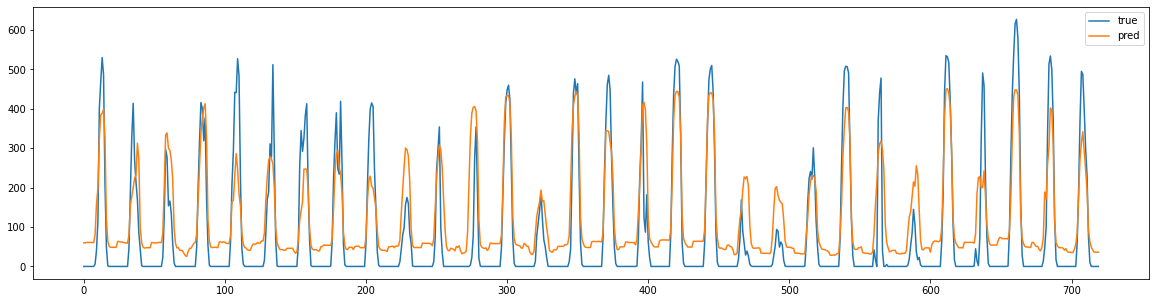

CV Score :  8.523591303464043


In [ ]:
pred = dangjin_floating_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

## 당진 자재 창고 태양광 예측 모델 학습

In [ ]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin_warehouse')
cat2 = CatBoostRegressor(n_estimators=1000 ,random_seed=42, learning_rate=0.01,depth = 8,loss_function='MAE')
cat2.fit(train_x, train_y,
                  eval_set=[(train_x, train_y), (val_x, val_y)],
                  early_stopping_rounds=100,verbose=100)

0:	learn: 137.2109303	test: 137.2109303	test1: 145.8724851	best: 145.8724851 (0)	total: 6.57ms	remaining: 6.56s
100:	learn: 77.1282411	test: 77.1282411	test1: 77.4142143	best: 77.4142143 (100)	total: 639ms	remaining: 5.69s
200:	learn: 57.5597617	test: 57.5597617	test1: 52.1786842	best: 52.1786842 (200)	total: 1.26s	remaining: 5.02s
300:	learn: 50.9650754	test: 50.9650754	test1: 42.8710902	best: 42.8710902 (300)	total: 1.88s	remaining: 4.37s
400:	learn: 48.2516149	test: 48.2516149	test1: 38.8489845	best: 38.8489845 (400)	total: 2.5s	remaining: 3.73s
500:	learn: 46.7115275	test: 46.7115275	test1: 36.4337697	best: 36.4337697 (500)	total: 3.12s	remaining: 3.1s
600:	learn: 45.5269393	test: 45.5269393	test1: 35.1580544	best: 35.1580544 (600)	total: 3.73s	remaining: 2.48s
700:	learn: 44.4936480	test: 44.4936480	test1: 34.2954770	best: 34.2870222 (699)	total: 4.34s	remaining: 1.85s
800:	learn: 43.5601875	test: 43.5601875	test1: 34.0132901	best: 34.0132901 (800)	total: 4.95s	remaining: 1.23s
90

In [ ]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin_warehouse')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 700
dangjin_warehouse_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=100, early_stopping_rounds=100)

NameError: ignored

## 당진 태양광 예측 모델 학습

In [ ]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin')
cat3 = CatBoostRegressor(n_estimators=1000 ,random_seed=42, learning_rate=0.01,depth = 8,loss_function='MAE')
cat3.fit(train_x, train_y,
                  eval_set=[(train_x, train_y), (val_x, val_y)],
                  early_stopping_rounds=100,verbose=100)

0:	learn: 204.3475780	test: 204.3475780	test1: 240.4799851	best: 240.4799851 (0)	total: 8.12ms	remaining: 8.11s
100:	learn: 118.3785368	test: 118.3785368	test1: 129.7208028	best: 129.7208028 (100)	total: 615ms	remaining: 5.48s
200:	learn: 90.6342721	test: 90.6342721	test1: 87.3536885	best: 87.3536885 (200)	total: 1.25s	remaining: 4.96s
300:	learn: 80.4348330	test: 80.4348330	test1: 66.8952317	best: 66.8952317 (300)	total: 1.85s	remaining: 4.31s
400:	learn: 76.0960948	test: 76.0960948	test1: 58.1472805	best: 58.1472805 (400)	total: 2.46s	remaining: 3.68s
500:	learn: 73.4230682	test: 73.4230682	test1: 53.4314458	best: 53.4314458 (500)	total: 3.06s	remaining: 3.05s
600:	learn: 71.3715198	test: 71.3715198	test1: 50.8747965	best: 50.8747965 (600)	total: 3.69s	remaining: 2.45s
700:	learn: 69.5185095	test: 69.5185095	test1: 49.8571925	best: 49.8281842 (689)	total: 4.31s	remaining: 1.84s
800:	learn: 67.9245237	test: 67.9245237	test1: 50.0085920	best: 49.7089523 (725)	total: 4.95s	remaining: 1.

In [ ]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 147.579	valid_0's score: 11.8649
[200]	valid_0's l1: 102.086	valid_0's score: 10.6793
[300]	valid_0's l1: 79.7547	valid_0's score: 10.6862
Early stopping, best iteration is:
[262]	valid_0's l1: 87.2042	valid_0's score: 10.6087


## 울산 태양광 예측 모델 학습

In [ ]:
train_x, train_y, val_x, val_y = train_datast(energy, ulsan_interpolated, target='ulsan')
cat4 = CatBoostRegressor(n_estimators=1000 ,random_seed=42, learning_rate=0.01,depth = 8,loss_function='MAE')
cat4.fit(train_x, train_y,
                  eval_set=[(train_x, train_y), (val_x, val_y)],
                  early_stopping_rounds=100,verbose=100)

0:	learn: 94.3367761	test: 94.3367761	test1: 103.5477629	best: 103.5477629 (0)	total: 6.58ms	remaining: 6.58s
100:	learn: 52.0063749	test: 52.0063749	test1: 52.5808973	best: 52.5808973 (100)	total: 659ms	remaining: 5.87s
200:	learn: 38.4944860	test: 38.4944860	test1: 34.7168757	best: 34.7168757 (200)	total: 1.3s	remaining: 5.16s
300:	learn: 33.7295921	test: 33.7295921	test1: 27.0655598	best: 27.0655598 (300)	total: 1.95s	remaining: 4.52s
400:	learn: 31.7561043	test: 31.7561043	test1: 23.0841819	best: 23.0841819 (400)	total: 2.56s	remaining: 3.82s
500:	learn: 30.7783330	test: 30.7783330	test1: 20.8173041	best: 20.8173041 (500)	total: 3.16s	remaining: 3.15s
600:	learn: 30.0841496	test: 30.0841496	test1: 19.6564799	best: 19.6564799 (600)	total: 3.78s	remaining: 2.51s
700:	learn: 29.3882119	test: 29.3882119	test1: 18.9971710	best: 18.9971710 (700)	total: 4.43s	remaining: 1.89s
800:	learn: 28.8160309	test: 28.8160309	test1: 18.6329313	best: 18.6329313 (800)	total: 5.05s	remaining: 1.25s
900

In [ ]:
train_x, train_y, val_x, val_y = train_datast(energy, ulsan_interpolated, target='ulsan')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 500
ulsan_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 59.406	valid_0's score: 9.54573
[200]	valid_0's l1: 35.6721	valid_0's score: 7.13568
[300]	valid_0's l1: 26.1022	valid_0's score: 6.41192
[400]	valid_0's l1: 20.8927	valid_0's score: 6.27364
[500]	valid_0's l1: 17.9528	valid_0's score: 6.21949
[600]	valid_0's l1: 15.0714	valid_0's score: 6.20034
[700]	valid_0's l1: 14.4103	valid_0's score: 6.18049
Early stopping, best iteration is:
[682]	valid_0's l1: 14.343	valid_0's score: 6.18864


## 테스트 데이터 전처리

In [ ]:
def test_datast(fcst_df):
    start = '2021-02-01 00:00:00'
    end = '2021-02-28 23:00:00'
    
    start_idx = fcst_df[fcst_df['Forecast_time']==start].index[0]
    end_idx = fcst_df[fcst_df['Forecast_time']==end].index[0]
    
    test_df = fcst_df.loc[start_idx:end_idx, :].copy()
    
    test_df['date'] = test_df['Forecast_time'].str.split(' ').str[0]
    test_df['hour'] = test_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    test_df['year'] = test_df['date'].str.split('-').str[0].astype(int)
    test_df['month'] = test_df['date'].str.split('-').str[1].astype(int)
    test_df['day'] = test_df['date'].str.split('-').str[2].astype(int)
    
    test_df = test_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    
    test_x = test_df.to_numpy()
    
    return test_x

In [ ]:
dangjin_test = test_datast(dangjin_interpolated)
ulsan_test = test_datast(ulsan_interpolated)

## 각 발전소 발전량 추론

In [ ]:
dangjin_floating_pred = dangjin_floating_model.predict(dangjin_test)
dangjin_warehouse_pred = dangjin_warehouse_model.predict(dangjin_test)
dangjin_pred = dangjin_model.predict(dangjin_test)
ulsan_pred = ulsan_model.predict(ulsan_test)

NameError: ignored

In [ ]:
dangjin_floating_pred = cat1.predict(dangjin_test)
dangjin_warehouse_pred = cat2.predict(dangjin_test)
dangjin_pred = cat3.predict(dangjin_test)
ulsan_pred = cat4.predict(ulsan_test)

## 제출

In [ ]:
submission = pd.read_csv('./data/sample_submission.csv')

In [ ]:
submission.iloc[:24*28, 1] = dangjin_floating_pred
submission.iloc[:24*28, 2] = dangjin_warehouse_pred
submission.iloc[:24*28, 3] = dangjin_pred
submission.iloc[:24*28, 4] = ulsan_pred

In [ ]:
submission['dangjin_floating'] = submission['dangjin_floating'].apply(lambda x : 0 if x < 0 else x)
submission['dangjin_warehouse'] = submission['dangjin_warehouse'].apply(lambda x : 0 if x < 0 else x)
submission['dangjin'] = submission['dangjin'].apply(lambda x : 0 if x < 0 else x)
submission['ulsan'] = submission['ulsan'].apply(lambda x : 0 if x < 0 else x)

In [ ]:
submission

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,0.0,4.600467,0.000000,0.00000
1,2021-02-01 02:00:00,0.0,3.415664,0.000000,0.00000
2,2021-02-01 03:00:00,0.0,2.449471,0.000000,0.00000
3,2021-02-01 04:00:00,0.0,4.896420,4.727909,0.00000
4,2021-02-01 05:00:00,0.0,4.457381,3.023084,2.13324
...,...,...,...,...,...
1387,2021-07-08 20:00:00,0.0,0.000000,0.000000,0.00000
1388,2021-07-08 21:00:00,0.0,0.000000,0.000000,0.00000
1389,2021-07-08 22:00:00,0.0,0.000000,0.000000,0.00000
1390,2021-07-08 23:00:00,0.0,0.000000,0.000000,0.00000


In [ ]:
cat_submission = pd.read_csv('cat_baseline.csv')

In [ ]:
submission.to_csv('cat_zero.csv', index=False)

In [ ]:
df1 = (cat_submission + submission)

In [ ]:
cat_submission[['dangjin_floating'	,'dangjin_warehouse'	,'dangjin'	,'ulsan']] = df1[['dangjin_floating'	,'dangjin_warehouse'	,'dangjin'	,'ulsan']]  / 2

In [ ]:
cat_submission['time'] = submission['time']
cat_submission

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,17.508576,21.154163,25.814101,0.292359
1,2021-02-01 02:00:00,12.393992,16.128685,22.799175,-1.878065
2,2021-02-01 03:00:00,13.030554,16.066100,24.364777,-1.271093
3,2021-02-01 04:00:00,13.413287,18.860513,25.650251,-3.078692
4,2021-02-01 05:00:00,13.586831,18.454538,26.517019,-2.456435
...,...,...,...,...,...
1387,2021-07-08 20:00:00,0.000000,0.000000,0.000000,0.000000
1388,2021-07-08 21:00:00,0.000000,0.000000,0.000000,0.000000
1389,2021-07-08 22:00:00,0.000000,0.000000,0.000000,0.000000
1390,2021-07-08 23:00:00,0.000000,0.000000,0.000000,0.000000


In [ ]:
cat_submission.to_csv('cat_lgb_baseline.csv', index=False)